Class distribution after upsampling:
condition_label
4    3844
0    3844
1    3844
2    3844
3    3844
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15376 [00:00<?, ? examples/s]

Map:   0%|          | 0/3844 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.832200,0.671170,0.734650,0.735692,0.711754,0.735692
2,0.605000,0.632889,0.751147,0.759625,0.741929,0.759625
3,0.512300,0.630758,0.759987,0.770291,0.759125,0.770291
4,0.446800,0.635135,0.762136,0.769771,0.754716,0.769771
5,0.391900,0.776993,0.779612,0.778356,0.753718,0.778356


Evaluation results: {'eval_loss': 0.6307582855224609, 'eval_precision': 0.7599866181577798, 'eval_recall': 0.7702913631633714, 'eval_f1': 0.7591249020892197, 'eval_accuracy': 0.7702913631633714, 'eval_runtime': 64.0678, 'eval_samples_per_second': 59.999, 'eval_steps_per_second': 3.762, 'epoch': 5.0}
Precision: 0.6278
Recall: 0.6247
F1 Score: 0.6128


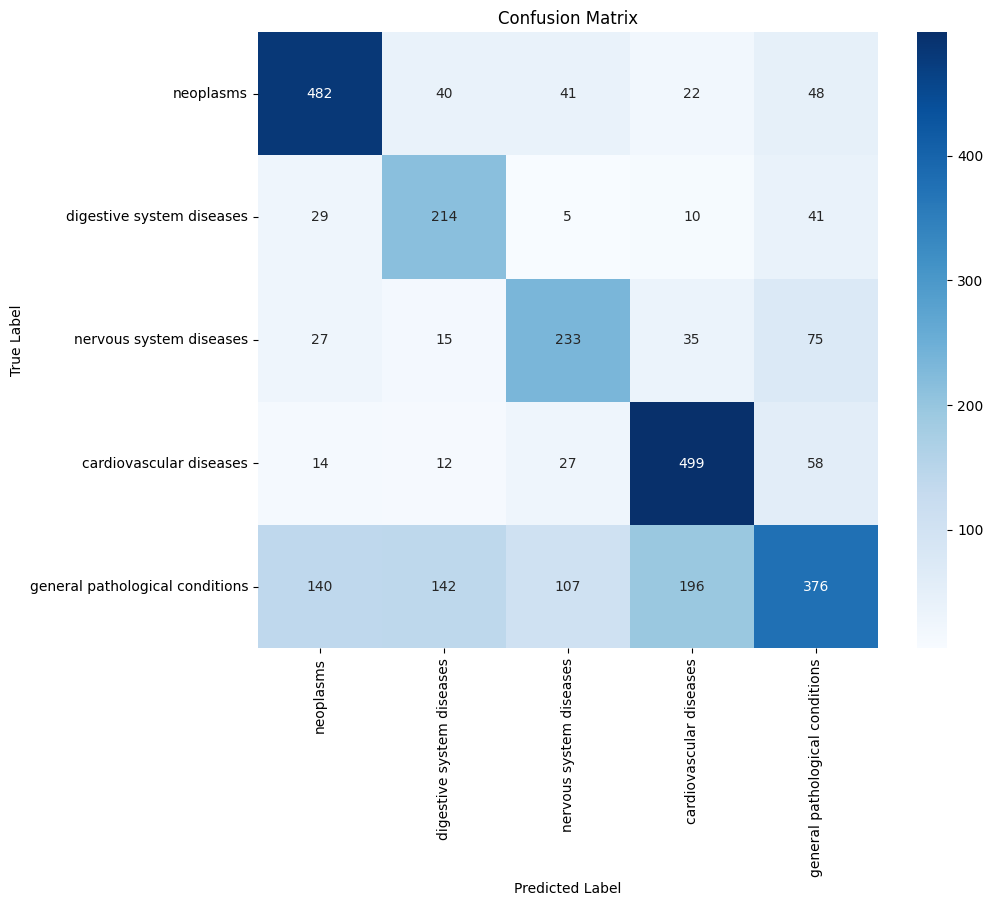

                                 precision    recall  f1-score   support

                      neoplasms       0.70      0.76      0.73       633
      digestive system diseases       0.51      0.72      0.59       299
        nervous system diseases       0.56      0.61      0.58       385
        cardiovascular diseases       0.65      0.82      0.73       610
general pathological conditions       0.63      0.39      0.48       961

                       accuracy                           0.62      2888
                      macro avg       0.61      0.66      0.62      2888
                   weighted avg       0.63      0.62      0.61      2888



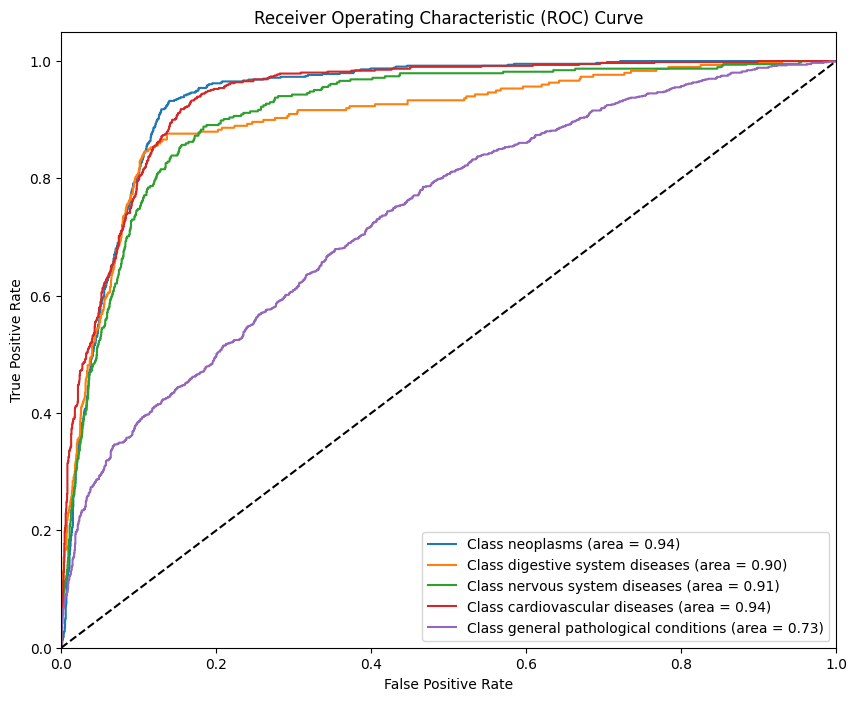

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

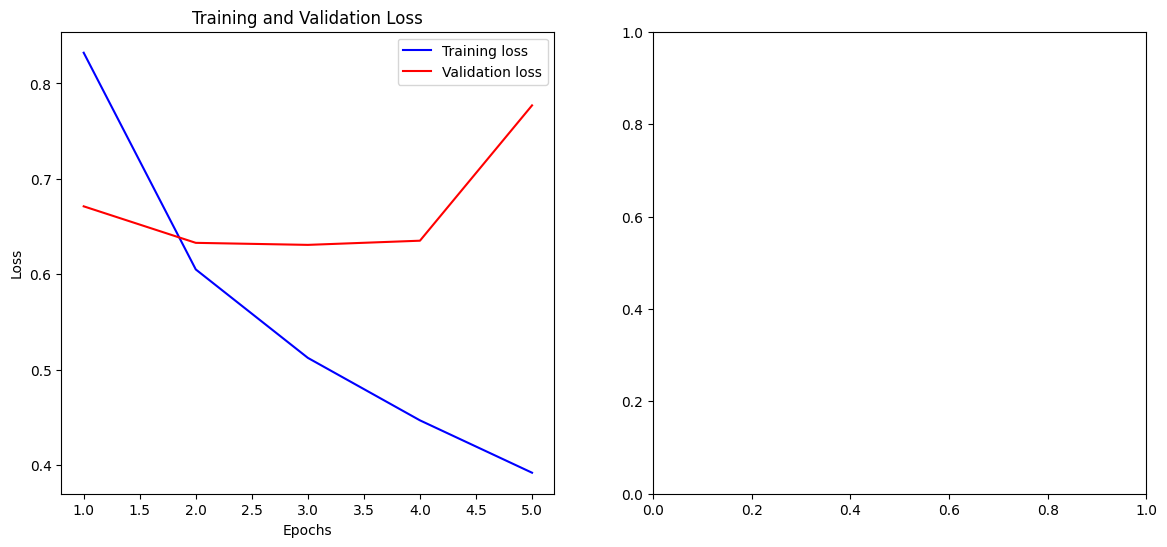

In [2]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"
# Load the data
train_data = pd.read_csv('/kaggle/input/medcon/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/medcon/medical_tc_test.csv')

# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Encode the labels
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Upsample minority classes to match the size of the largest class
max_size = train_data['condition_label'].value_counts().max()
lst = [train_data]
for class_index, group in train_data.groupby('condition_label'):
    lst.append(group.sample(max_size - len(group), replace=True))
train_data_balanced = pd.concat(lst)

# Print the class distribution after upsampling
print("Class distribution after upsampling:")
print(train_data_balanced['condition_label'].value_counts())

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['condition_label'], random_state=42)

# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.1', num_labels=len(label_dict))

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'condition_label' to 'labels'
train_dataset = train_dataset.rename_column("condition_label", "labels")
val_dataset = val_dataset.rename_column("condition_label", "labels")
test_dataset = test_dataset.rename_column("condition_label", "labels")

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.1,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation results: {eval_results}")

# Get predictions
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Calculate precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(labels, preds, target_names=label_dict.values())
print(report)

# ROC Curve and AUROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(labels, preds_output.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Class distribution after balancing:
condition_label
0    2441
1    2441
2    2441
3    2441
4    2441
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9764 [00:00<?, ? examples/s]

Map:   0%|          | 0/2441 [00:00<?, ? examples/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.891800,0.734405,0.710948,0.722245,0.695513,0.722245
2,0.650700,0.673272,0.732802,0.744367,0.732859,0.744367
3,0.551800,0.680021,0.739268,0.748873,0.729041,0.748873
4,0.465900,0.725133,0.744514,0.753380,0.734856,0.753380


Evaluation results on validation set: {'eval_loss': 0.6732723116874695, 'eval_precision': 0.7328018501670155, 'eval_recall': 0.7443670626792298, 'eval_f1': 0.732859214868868, 'eval_accuracy': 0.7443670626792298, 'eval_runtime': 40.7614, 'eval_samples_per_second': 59.885, 'eval_steps_per_second': 3.754, 'epoch': 4.0}
Test Precision: 0.6675
Test Recall: 0.6569
Test F1 Score: 0.6419


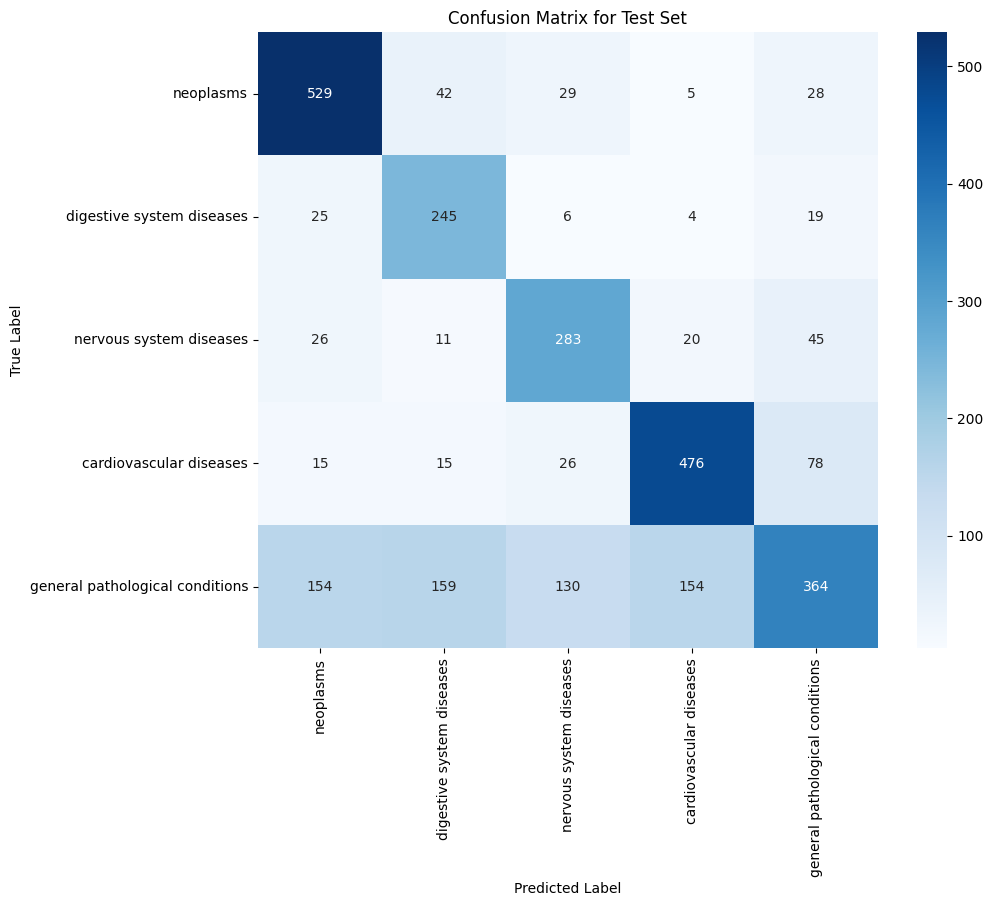

                                 precision    recall  f1-score   support

                      neoplasms       0.71      0.84      0.77       633
      digestive system diseases       0.52      0.82      0.64       299
        nervous system diseases       0.60      0.74      0.66       385
        cardiovascular diseases       0.72      0.78      0.75       610
general pathological conditions       0.68      0.38      0.49       961

                       accuracy                           0.66      2888
                      macro avg       0.65      0.71      0.66      2888
                   weighted avg       0.67      0.66      0.64      2888



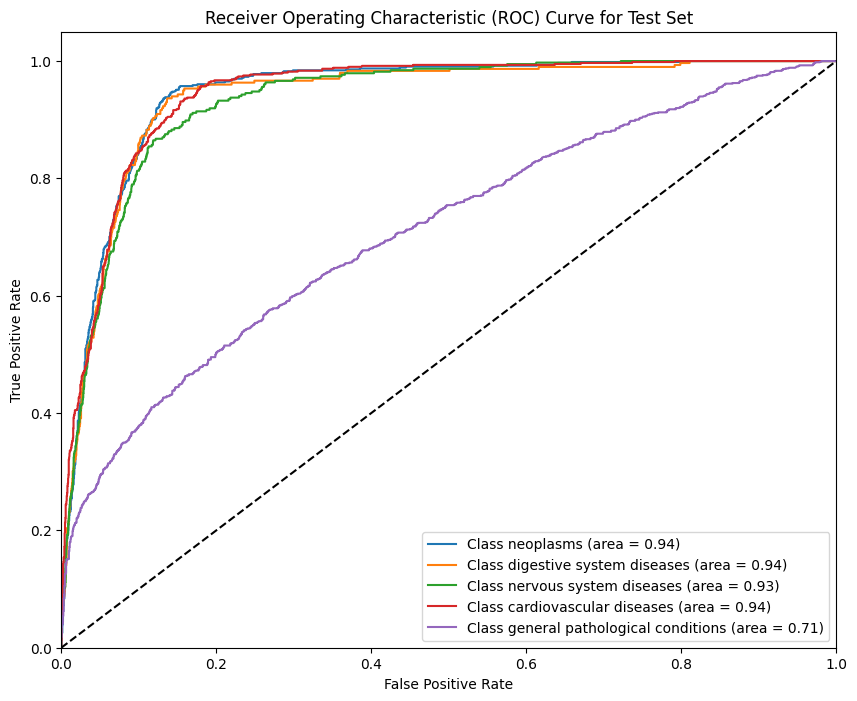

ValueError: x and y must have same first dimension, but have shapes (4,) and (0,)

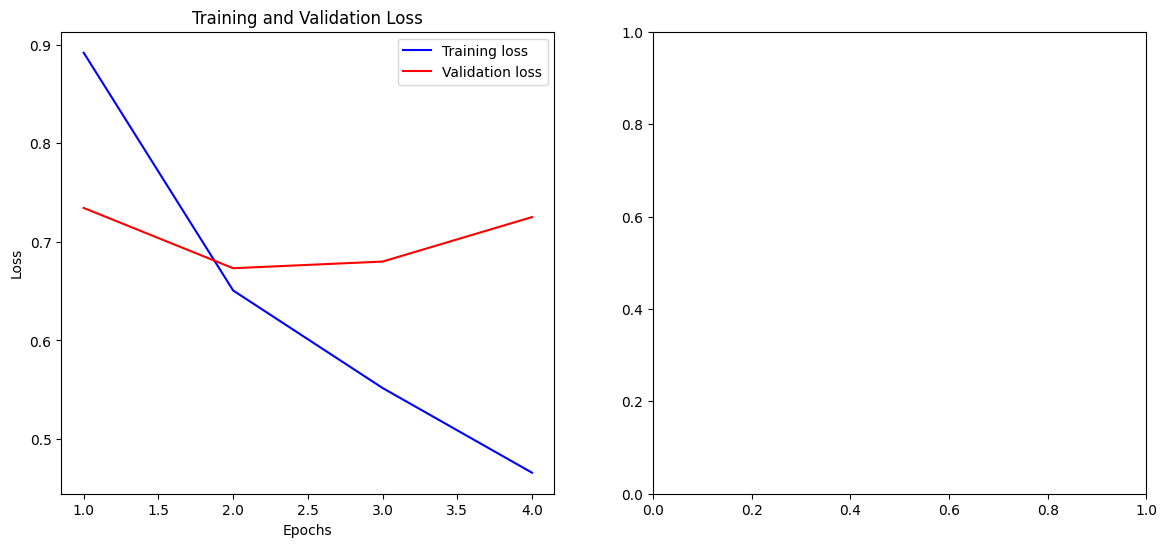

In [4]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load the data
train_data = pd.read_csv('/kaggle/input/medcon/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/medcon/medical_tc_test.csv')

# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Encode the labels
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Determine the target size for balancing
target_size = train_data['condition_label'].value_counts().median()

# Separate each class into a different dataframe
dfs = [train_data[train_data.condition_label == i] for i in range(len(label_dict))]

# Upsample minority classes and downsample the majority class to the target size
dfs_balanced = [resample(df, replace=True, n_samples=int(target_size), random_state=123) if len(df) < target_size else resample(df, replace=False, n_samples=int(target_size), random_state=123) for df in dfs]

# Combine all the balanced dataframes
train_data_balanced = pd.concat(dfs_balanced)

# Print the class distribution after balancing
print("Class distribution after balancing:")
print(train_data_balanced['condition_label'].value_counts())

# Rename 'condition_label' to 'labels' for consistency with Hugging Face datasets
train_data_balanced.rename(columns={'condition_label': 'labels'}, inplace=True)
test_data.rename(columns={'condition_label': 'labels'}, inplace=True)

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['labels'], random_state=42)

# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.1', num_labels=len(label_dict))

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.1,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Evaluation results on validation set: {eval_results}")

# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate precision, recall, f1-score for test set
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Classification report for test set
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)

# ROC Curve and AUROC for test set
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [9]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load the data
train_data = pd.read_csv('/kaggle/input/medcon/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/medcon/medical_tc_test.csv')

# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Remove the "general pathological conditions" class (label 5)
train_data = train_data[train_data['condition_label'] != 5]
test_data = test_data[test_data['condition_label'] != 5]

# Update the label dictionary to exclude "general pathological conditions"
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases"
}

# Encode the labels (subtract 1 to make them zero-indexed)
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Determine the target size for balancing
target_size = train_data['condition_label'].value_counts().median()

# Separate each class into a different dataframe
dfs = [train_data[train_data.condition_label == i] for i in range(len(label_dict))]

# Upsample minority classes and downsample the majority class to the target size
dfs_balanced = [resample(df, replace=True, n_samples=int(target_size), random_state=123) if len(df) < target_size else resample(df, replace=False, n_samples=int(target_size), random_state=123) for df in dfs]

# Combine all the balanced dataframes
train_data_balanced = pd.concat(dfs_balanced)

# Print the class distribution after balancing
print("Class distribution after balancing:")
print(train_data_balanced['condition_label'].value_counts())

# Rename 'condition_label' to 'labels' for consistency with Hugging Face datasets
train_data_balanced.rename(columns={'condition_label': 'labels'}, inplace=True)
test_data.rename(columns={'condition_label': 'labels'}, inplace=True)

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['labels'], random_state=42)

# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.1', num_labels=len(label_dict))

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = train_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.1,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Evaluation results on validation set: {eval_results}")

# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate precision, recall, f1-score for test set
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Classification report for test set
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)

# ROC Curve and AUROC for test set
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Class distribution after balancing:
condition_label
0    1990
1    1990
2    1990
3    1990
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6368 [00:00<?, ? examples/s]

Map:   0%|          | 0/6368 [00:00<?, ? examples/s]

Map:   0%|          | 0/6368 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.589400,0.289514,0.896278,0.892588,0.892944,0.892588
2,0.310500,0.244572,0.922455,0.917085,0.916336,0.917085
3,0.243000,0.155133,0.940727,0.940170,0.940057,0.940170
4,0.194800,0.138855,0.956654,0.956030,0.955973,0.956030
5,0.161900,0.110512,0.959460,0.958700,0.958756,0.958700
6,0.133000,0.089062,0.964928,0.964196,0.964122,0.964196
7,0.111000,0.071078,0.966215,0.965609,0.965583,0.965609


RuntimeError: [enforce fail at inline_container.cc:424] . unexpected pos 565145344 vs 565145232

Test Precision: 0.9662
Test Recall: 0.9656
Test F1 Score: 0.9656


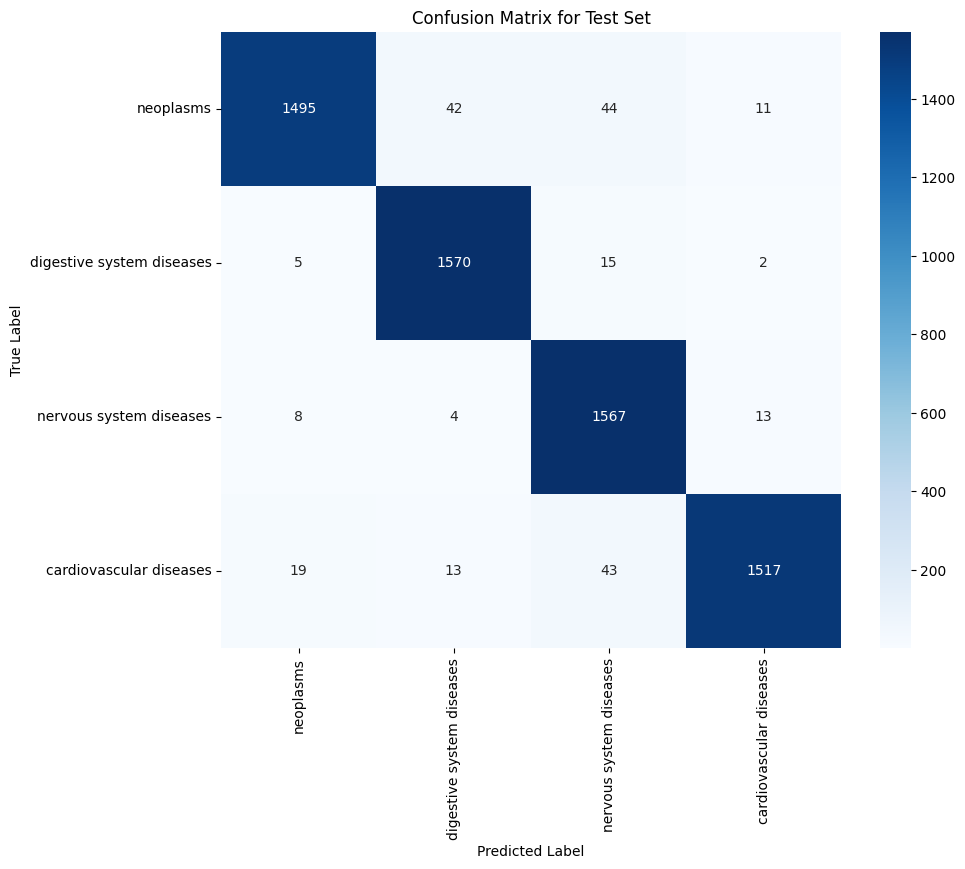

                           precision    recall  f1-score   support

                neoplasms       0.98      0.94      0.96      1592
digestive system diseases       0.96      0.99      0.97      1592
  nervous system diseases       0.94      0.98      0.96      1592
  cardiovascular diseases       0.98      0.95      0.97      1592

                 accuracy                           0.97      6368
                macro avg       0.97      0.97      0.97      6368
             weighted avg       0.97      0.97      0.97      6368



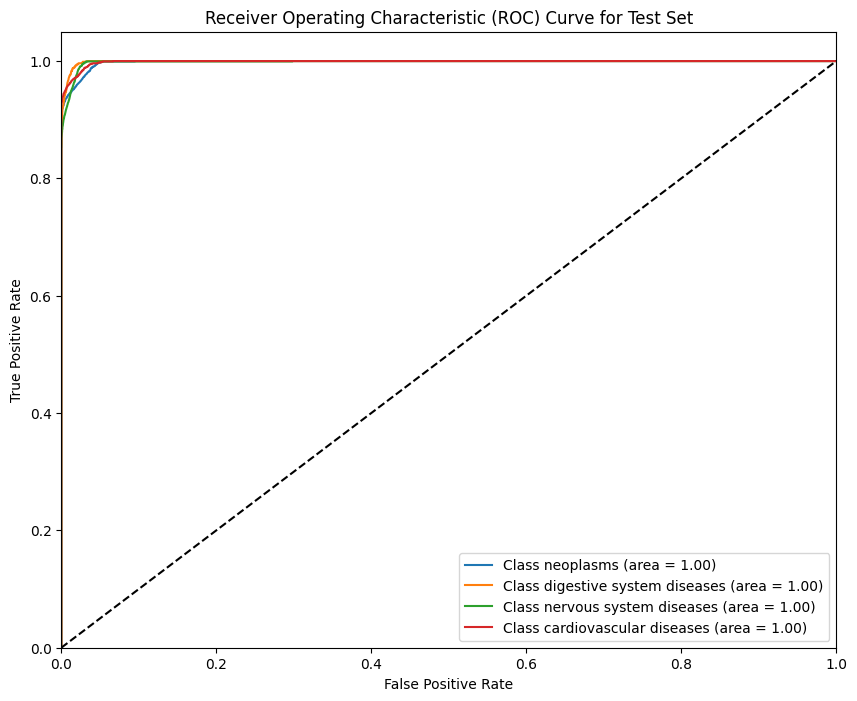

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

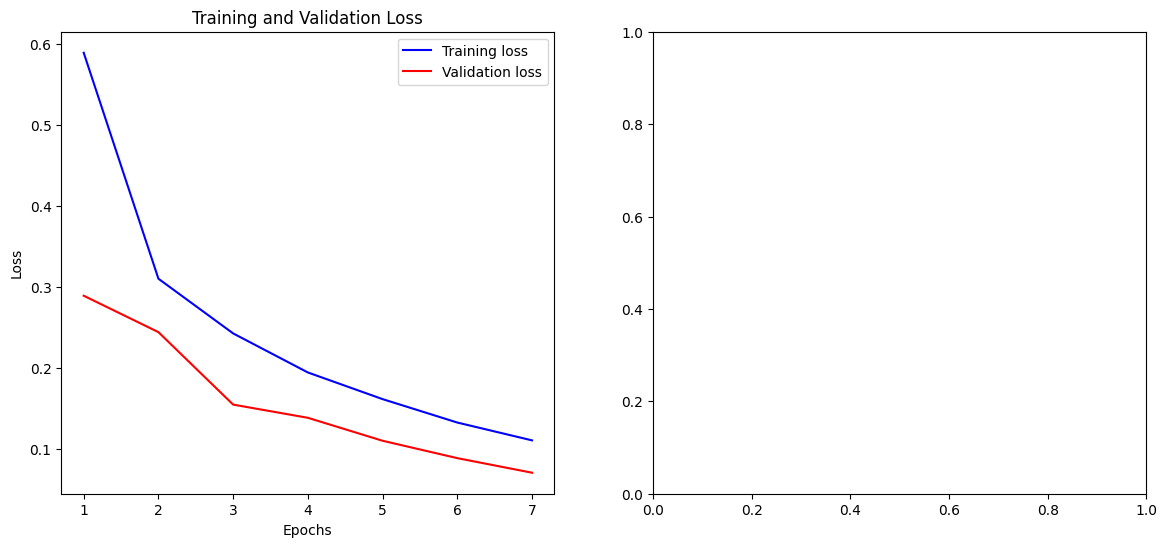

In [10]:
# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate precision, recall, f1-score for test set
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Classification report for test set
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)

# ROC Curve and AUROC for test set
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

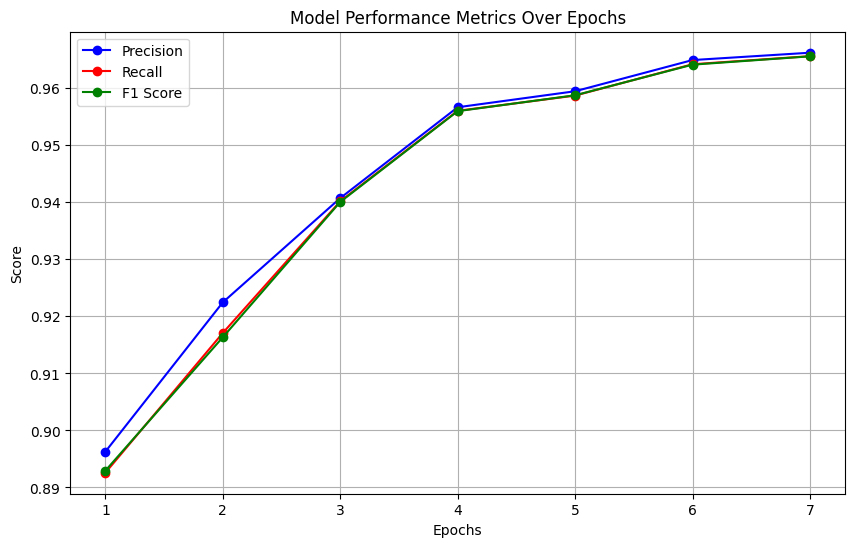

In [11]:
import matplotlib.pyplot as plt

# Data for the new set of epochs
epochs = [1, 2, 3, 4, 5, 6, 7]
precision = [0.896278, 0.922455, 0.940727, 0.956654, 0.959460, 0.964928, 0.966215]
recall = [0.892588, 0.917085, 0.940170, 0.956030, 0.958700, 0.964196, 0.965609]
f1 = [0.892944, 0.916336, 0.940057, 0.955973, 0.958756, 0.964122, 0.965583]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, 'b-o', label='Precision')
plt.plot(epochs, recall, 'r-o', label='Recall')
plt.plot(epochs, f1, 'g-o', label='F1 Score')

# Titles and labels
plt.title('Model Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


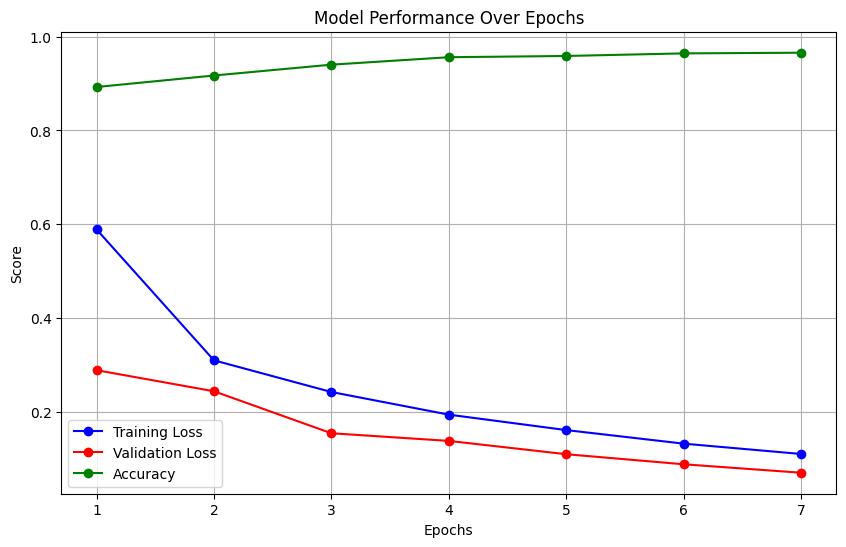

In [12]:
import matplotlib.pyplot as plt

# Data for the new set of epochs
epochs = [1, 2, 3, 4, 5, 6, 7]
training_loss = [0.589400, 0.310500, 0.243000, 0.194800, 0.161900, 0.133000, 0.111000]
validation_loss = [0.289514, 0.244572, 0.155133, 0.138855, 0.110512, 0.089062, 0.071078]
accuracy = [0.892588, 0.917085, 0.940170, 0.956030, 0.958700, 0.964196, 0.965609]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-o', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')
plt.plot(epochs, accuracy, 'g-o', label='Accuracy')

# Titles and labels
plt.title('Model Performance Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
